In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

from pathlib import Path

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
META_DIR = Path('data/fma_metadata')
AUDIO_DIR = Path('data/fma_small')

## Helper functions

In [3]:
# From https://github.com/mdeff/fma/blob/master/utils.py

def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')


def get_tids_from_directory(audio_dir):
    """Get track IDs from the mp3s in a directory.
    Parameters
    ----------
    audio_dir : str
        Path to the directory where the audio files are stored.
    Returns
    -------
        A list of track IDs.
    """
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids

In [4]:
tids = get_tids_from_directory(AUDIO_DIR)

In [5]:
tids[:10]

[14570, 14568, 14569, 459, 256, 255, 368, 182, 11638, 10250]

In [6]:
get_audio_path(AUDIO_DIR, 255)

'data/fma_small/000/000255.mp3'

# Read in metadata

In [7]:
tracks = pd.read_csv(META_DIR/'tracks.csv', index_col=0, header=[0, 1]) 

In [8]:
tracks.head(2)

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   

                                                         ...       track  \
         favorites id information listens producer tags  ... information   
track_id                                                 ...               
2                4  1     <p></p>    6073      NaN   []  ...         NaN   
3                4  1     <p></p>    6073      NaN   []  ...         NaN   

                                 \
         interest language_code   
track_id                          
2            4656            en   
3            1470            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   

                                              
         number publisher tags         title  
track_id                                      
2             3       NaN   []          Food  
3             4       NaN   []  Electric Ave  

[2 rows x 52 columns]

In [9]:
keep_cols = [('set', 'split'),
('set', 'subset'),('track', 'genre_top')]

df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']
df_all['track_id'] = df_all.index
df_all.head()

set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [10]:
df_all.shape

(8000, 4)

In [11]:
df_all[('track', 'genre_top')].value_counts()

Folk             1000
Instrumental     1000
Rock             1000
International    1000
Experimental     1000
Pop              1000
Electronic       1000
Hip-Hop          1000
Name: (track, genre_top), dtype: int64

## Trim down to 2 genres

In [12]:
mask = (df_all[('track', 'genre_top')]=='Rock') | (df_all[('track', 'genre_top')]=='Instrumental')
two_genre = df_all[mask]

In [13]:
two_genre.head()

set            track track_id
               split subset genre_top         
track_id                                      
182             test  small      Rock      182
255         training  small      Rock      255
256         training  small      Rock      256
368         training  small      Rock      368
459       validation  small      Rock      459

In [14]:
two_genre[('track', 'genre_top')].value_counts()

Instrumental    1000
Rock            1000
Name: (track, genre_top), dtype: int64

# Create Spectrograms

In [20]:
# From https://github.com/priya-dwivedi/Music_Genre_Classification/blob/master/Plot_Spectograms.ipynb

def plot_spectrogram(track_id, genre):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    print(len(y),sr)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
    spect = librosa.power_to_db(spect, ref=np.max)
#     spect = np.log(spect)
    print(spect.shape, genre)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(str(genre))

/anaconda3/envs/genre/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


661248 22050
(128, 1292) Rock


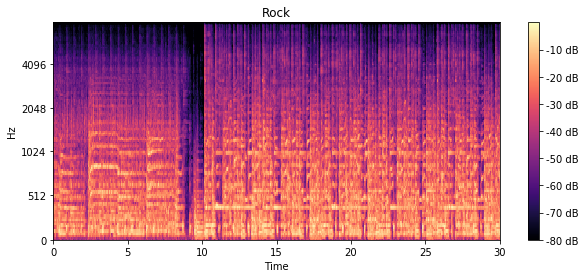

In [22]:
plot_spectrogram(255, "Rock")

/anaconda3/envs/genre/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


661824 22050
(128, 1293) Instrumental


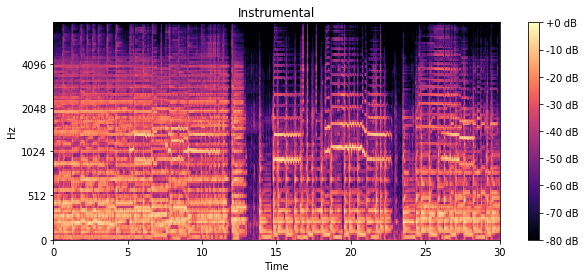

In [23]:
plot_spectrogram(14569, "Instrumental")